In [1]:
import numpy as np
import pandas as pd
import gensim
import nltk
import re
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score

from gensim.models import word2vec
import gensim.downloader as api

from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
import os
import seaborn as sn
import pickle


In [2]:
model = api.load('word2vec-google-news-300')

In [3]:
df = pd.read_csv('./HASOC/cleaned_data_train.csv')
df_test = pd.read_csv('./HASOC/cleaned_data_test.csv')
df.dropna()
df_test.dropna()
df['task1'].replace(['NOT', 'HOF'],[0, 1], inplace=True)
df_test['task1'].replace(['NOT', 'HOF'],[0, 1], inplace=True)

In [4]:
lemattized = []
for lem in df.lemattized:
    res = lem.strip('][').replace("'", '').split(', ')
    lemattized.append(res)


In [5]:
lemattized_test = []
for lem in df_test.lemattized:
    res = lem.strip('][').replace("'", '').split(', ')
    lemattized_test.append(res)


In [6]:
y_train = np.asarray(df["task1"])
y_test = np.asarray(df_test["task1"])


In [7]:
all_words = [token for seq in lemattized for token in seq]
all_words
print('Review example: ', all_words[:20])
print('Label: ',y_train[0])

Review example:  ['hate', 'females', 'nigga', 'tryna', 'make', 'sweety', 'fuck', 'airjunebug', 'really', 'nigga', 'heart', 'supportcaleon', 'donaldjtrumpjr', 'dear', 'democrats', 'american', 'people', 'stupid', 'know', 'spy']
Label:  1


In [8]:
X_train = np.asarray([(" ".join(seq)) for seq in lemattized])
X_test = np.asarray([(" ".join(seq)) for seq in lemattized_test])
X_train[0]
# print(len(X_train), len(X_test))


'hate females nigga tryna make sweety fuck'

In [9]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling


def display_closestwords_tsnescatterplot(model, dim, words):

    arr = np.empty((0, dim), dtype='f')
    word_labels = words

    # get close words
    #close_words = [model.similar_by_word(word) for word in words]

    # add the vector for each of the closest words to the array
    close_words = []
    for word in words:
        arr = np.append(arr, np.array([model[word]]), axis=0)
        close_words += model.similar_by_word(word)

    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)

    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    #np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(
            0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()


def tsne_plot(model, words):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    #for word in model.wv.vocab:
    for word in words:
        tokens.append(model[word])
        labels.append(word)

    tsne_model = TSNE(perplexity=40, n_components=2,
                      init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(14, 10))
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()


/Users/adi/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/adi/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


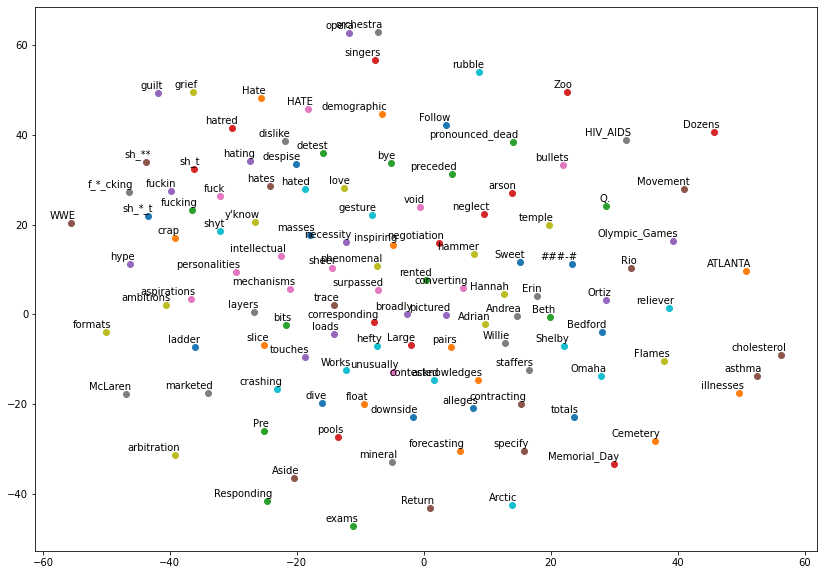

In [10]:
#display_closestwords_tsnescatterplot(model, 100, ['man', 'dog'])
words=list(model.index_to_key)
word1 = words[10000:10100]
words2= model.similar_by_word('hate')
words3= model.similar_by_word('shit')
words= word1 + [w[0] for w in words2] + [w[0] for w in words3]
#print(words)
tsne_plot(model, words)

In [11]:
class Word2VecVectorizer:
  def __init__(self, model):
    print("Loading in word vectors...")
    self.word_vectors = model
    print("Finished loading in word vectors")

  def fit(self, data):
    pass

  def transform(self, data):
    # determine the dimensionality of vectors
    v = self.word_vectors.get_vector('shit')
    self.D = v.shape[0]

    X = np.zeros((len(data), self.D))
    n = 0
    emptycount = 0
    for sentence in data:
      tokens = sentence.split()
      vecs = []
      m = 0
      for word in tokens:
        try:
          # throws KeyError if word not found
          vec = self.word_vectors.get_vector(word)
          vecs.append(vec)
          m += 1
        except KeyError:
          pass
      if len(vecs) > 0:
        vecs = np.array(vecs)
        X[n] = vecs.mean(axis=0)
      else:
        emptycount += 1
      n += 1
    print("Numer of samples with no words found: %s / %s" %
          (emptycount, len(data)))
    return X

  def fit_transform(self, data):
    self.fit(data)
    return self.transform(data)


In [20]:
# Set a word vectorizer
vectorizer = Word2VecVectorizer(model)
print(X_train)
# Get the sentence embeddings for the train dataset
Xtrain = vectorizer.fit_transform(X_train)
Ytrain = y_train
# Get the sentence embeddings for the test dataset
Xtest = vectorizer.transform(X_test)
Ytest = y_test

Loading in word vectors...
Finished loading in word vectors
['hate females nigga tryna make sweety fuck'
 'airjunebug really nigga heart supportcaleon'
 'donaldjtrumpjr dear democrats american people stupid know spy amount gaslighting change'
 ...
 'flytpa break news even better plan 2020 mother nurse room water bottle fill'
 'starrtharapper fuck game' 'know know']
Numer of samples with no words found: 24 / 3552
Numer of samples with no words found: 9 / 1514


In [13]:
print(Xtrain.shape,Xtest.shape)

(3552, 300) (1514, 300)


In [14]:
# Create the confussion matrix
def plot_confussion_matrix(y_test, y_pred, figNumber):
    ''' Plot the confussion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    print('tn - ' + str(tn))
    print('fp - ' + str(fp))
    print('fn - ' + str(fn))
    print('tp - ' + str(tp))

    # Create a dataframe with the confussion matrix values
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                         range(cm.shape[1]))
    #plt.figure(figsize = (10,7))
    # Plot the confussion matrix
    sn.set(font_scale=1.4)  # for label size
    sn.heatmap(df_cm, annot=True, fmt='.0f',
               annot_kws={"size": 10})  # font size
    plt.ylabel('Predicted Values')
    plt.xlabel('True Values')
    plt.savefig('./confusion_matrix ' + str(figNumber) + '.jpg')
    plt.show()

# ROC Curve
# plot no skill
# Calculate the points in the ROC curve


def plot_roc_curve(y_test, y_pred):
    ''' Plot the ROC curve for the target labels and predictions'''
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    print(tpr)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


In [15]:
from sklearn.ensemble import RandomForestClassifier

# create the model, train it, print scores
clf = RandomForestClassifier(n_estimators=200)

clf.fit(Xtrain, Ytrain)

print("train score:", clf.score(Xtrain, Ytrain))
print("test score:", clf.score(Xtest, Ytest))


train score: 0.9954954954954955
test score: 0.8295904887714664


              precision    recall  f1-score   support

           0       0.80      0.91      0.85       763
           1       0.90      0.76      0.83       751

    accuracy                           0.84      1514
   macro avg       0.85      0.84      0.84      1514
weighted avg       0.85      0.84      0.84      1514

tn - 697
fp - 66
fn - 177
tp - 574


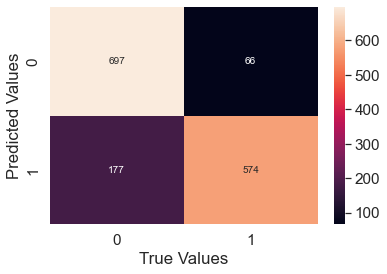

[0.         0.76431425 1.        ]


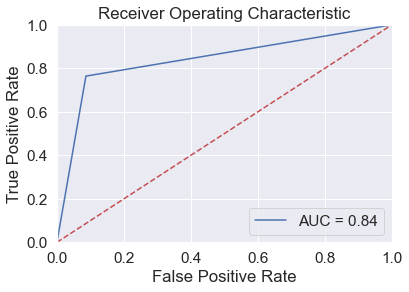

In [48]:
# Predicting the Test set results
y_pred = clf.predict(Xtest)

print(metrics.classification_report(Ytest, y_pred,  digits=2))
plot_confussion_matrix(Ytest, y_pred, 'Random Forest')
plot_roc_curve(Ytest, y_pred)


In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the parameters to tune
parameters = {
    'C': [1.0, 10],
    'gamma': [1, 'auto', 'scale']
}
# Tune yyperparameters  using Grid Search and a SVM model
model = GridSearchCV(SVC(kernel='rbf'), parameters,
                     cv=5, n_jobs=-1).fit(Xtrain, Ytrain)


              precision    recall  f1-score   support

           0       0.81      0.94      0.87       763
           1       0.93      0.78      0.85       751

    accuracy                           0.86      1514
   macro avg       0.87      0.86      0.86      1514
weighted avg       0.87      0.86      0.86      1514

[[718  45]
 [163 588]]


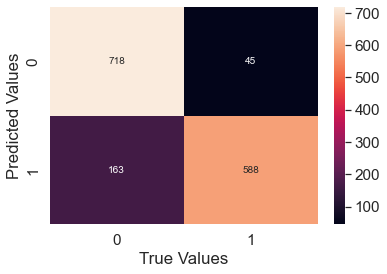

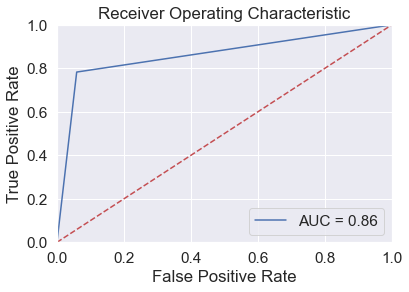

In [38]:
# Predicting the Test set results
y_pred = model.predict(Xtest)

print(metrics.classification_report(Ytest, y_pred,  digits=2))
plot_confussion_matrix(Ytest, y_pred, 'Support Vector Machine')
plot_roc_curve(Ytest, y_pred)


In [39]:
from sklearn.naive_bayes import GaussianNB,BernoulliNB

model = GaussianNB()
model.fit(Xtrain, Ytrain)

print("train score:", model.score(Xtrain, Ytrain))
print("test score:", model.score(Xtest, Ytest))


train score: 0.8161599099099099
test score: 0.8190224570673712


              precision    recall  f1-score   support

           0       0.76      0.93      0.84       763
           1       0.91      0.70      0.79       751

    accuracy                           0.82      1514
   macro avg       0.84      0.82      0.82      1514
weighted avg       0.84      0.82      0.82      1514

[[711  52]
 [222 529]]


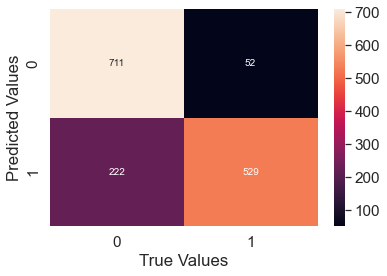

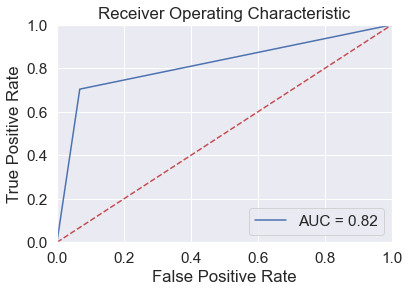

In [40]:
# Predicting the Test set results
y_pred = model.predict(Xtest)

print(metrics.classification_report(Ytest, y_pred,  digits=2))
plot_confussion_matrix(Ytest, y_pred, 'Naive Bayes')
plot_roc_curve(Ytest, y_pred)